Visualizing trajectories.

In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Working on new docking oracles.

In [3]:
from dgym.envs.oracle import DockingOracle, NeuralOracle, NoisyOracle
from dgym.envs.utility import ClassicUtilityFunction

config = {
    'center_x': 44.294,
    'center_y': 28.123,
    'center_z': 2.617,
    'size_x': 15.0,
    'size_y': 15.0,
    'size_z': 15.0,
    'search_mode': 'balanced',
    'scoring': 'gnina',
    'seed': 5
}

# Create noiseless evaluators
docking_oracle = DockingOracle(
    'ADAM17 affinity',
    receptor_path=f'../../dgym-data/ADAM17.pdbqt',
    config=config
)

docking_utility = ClassicUtilityFunction(
    docking_oracle,
    ideal=(9.5, 11.5),
    acceptable=(7.125, 9.5)
)

# Create noisy evaluator
noisy_docking_oracle = NoisyOracle(
    docking_oracle,
    sigma=0.7
)

noisy_docking_utility = ClassicUtilityFunction(
    noisy_docking_oracle,
    ideal=(8.5, 9.5),
    acceptable=(7.125, 9.5)
)

Run experiment.

In [441]:
from dgym.molecule import Molecule
from dgym.envs.designer import Designer, Generator
from dgym.envs.drug_env import DrugEnv
from dgym.agents import SequentialDrugAgent
from dgym.agents.exploration import EpsilonGreedy
from dgym.experiment import Experiment

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

drug_env = DrugEnv(
    designer,
    library = deck[10:15].update_annotations(),
    assays = [docking_utility.oracle.reset_cache()],
    budget = 400,
    utility_function = docking_utility,
)

sequence = [
    {'name': 'ideate', 'parameters': {'temperature': 0.1, 'size': 5, 'strict': False}},
    {'name': 'ideate', 'parameters': {'temperature': 0.1, 'size': 5, 'strict': True}},
    {'name': 'ADAM17 affinity'},
]

drug_agent = SequentialDrugAgent(
    sequence = sequence,
    utility_function = docking_utility,
    exploration_strategy = EpsilonGreedy(epsilon = 0.0),
    branch_factor = 2
)

experiment = Experiment(drug_agent, drug_env)

print(experiment.drug_env.assays['ADAM17 affinity'](experiment.drug_env.library)[0])
result = experiment.run(1, progress=True)

5.588849798230101


  0%|                                         | 0/1 [00:00<?, ?it/s]


  0%|                                       | 0/400 [00:00<?, ?it/s]

5.588849798230101


 56%|████████████████▏            | 223/400 [29:27<23:23,  7.93s/it]



  6%|█▉                            | 26/400 [00:06<01:29,  4.20it/s]


  9%|██▋                           | 36/400 [00:14<02:39,  2.28it/s]

7.775414174426121
7.775414174426121





 10%|███                           | 41/400 [00:36<07:28,  1.25s/it]

7.775414174426121





 13%|███▊                          | 51/400 [00:44<06:24,  1.10s/it]

7.875958537546908
7.875958537546908





 14%|████▎                         | 57/400 [01:10<10:36,  1.86s/it]

7.875958537546908





 17%|█████                         | 67/400 [01:18<08:15,  1.49s/it]

8.034029438187412
8.034029438187412





 19%|█████▊                        | 77/400 [01:58<12:35,  2.34s/it]

8.034029438187412
8.034029438187412
8.034029438187412





 22%|██████▌                       | 87/400 [02:38<14:59,  2.87s/it]

8.034029438187412
8.105627651418333
8.105627651418333





 24%|███████▎                      | 97/400 [03:20<16:35,  3.28s/it]

8.105627651418333
8.105627651418333
8.105627651418333


  0%|                                         | 0/1 [03:37<?, ?it/s]


KeyboardInterrupt: 

Visualizing affinity in chemical networks.

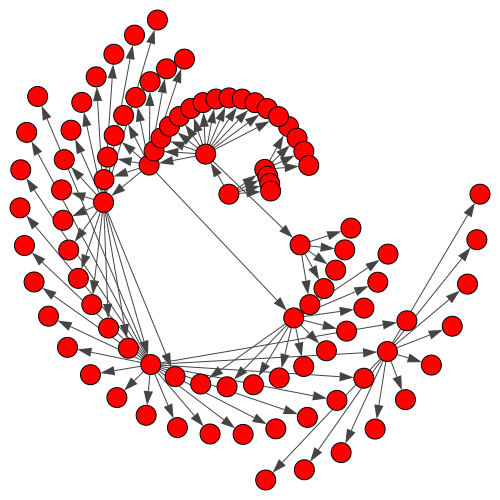

In [445]:
import math
import numpy as np
import igraph as ig

graph_scores = []
adjacency_tuples = []
for molecule in drug_env.library:
    if molecule.inspiration \
        and molecule.inspiration != molecule:
        adjacency_tuple = (molecule.inspiration.name, molecule.name)
        adjacency_tuples.append(adjacency_tuple)
    else:
        adjacency_tuple = ('parent', molecule.name)
        adjacency_tuples.append(adjacency_tuple)

g = ig.Graph.TupleList(set(adjacency_tuples), directed=True)


def convert_to_radial_layout(coordinates, radius_scale=1, rotate=0, extent=360):
    """
    Convert Feingold-Tillman layout coordinates to a radial layout.

    Parameters
    ----------
    coordinates : list of list of float
        A list where each element is a [x, y] pair representing the original
        coordinates of each node in the Feingold-Tillman layout. The x-axis
        is spaced, and the y-axis represents the depth of the tree.
    radius_scale : float, optional
        A scaling factor for the radius, by default 1.
    rotate : int, optional
        The initial rotation angle in degrees, by default 0.
    extent : int, optional
        The angular extent of the layout in degrees, by default 360.

    Returns
    -------
    np.ndarray
        An array of transformed coordinates in the radial layout, where each
        element is an [x, y] pair.

    Note
    ----
    - Requires `numpy` package.
    """

    # Convert coordinates to a numpy array for ease of computation
    coords = np.array(coordinates)
    
    # Normalize the x-axis values to [0, 1] (alpha)
    x_min, x_max = np.min(coords[:, 0]), np.max(coords[:, 0])
    alphas = (coords[:, 0] - x_min) / (x_max - x_min)
    
    # Calculate angles in radians
    angles = np.radians(rotate + extent * alphas + 270) % np.radians(360)
    
    # Calculate the radius from the center based on the depth, with optional scaling
    radii = coords[:, 1] * radius_scale
    
    # Calculate the final x and y positions
    x_positions = radii * np.cos(angles)
    y_positions = radii * np.sin(angles)
    
    new_coords = np.column_stack((x_positions, y_positions))
    
    return ig.layout.Layout(new_coords)

layout = g.layout("rt_circular")
ig.plot(
    g,
    layout=layout,
    bbox=(500, 500),
    # target='mygraph.png'
)

In [443]:
import seaborn as sns

palette = sns.color_palette("magma", as_cmap=True)

def normalize_array(arr):
    """
    Normalize a numpy array to have its minimum and maximum values scaled to 0 and 1, respectively.
    
    Parameters
    ----------
    arr : np.ndarray
        The input array to normalize.
    
    Returns
    -------
    np.ndarray
        The normalized array with values scaled between 0 and 1.
    
    Example
    -------
    >>> arr = np.array([10, 20, 30, 40, 50])
    >>> normalize_array(arr)
    array([0. , 0.25, 0.5 , 0.75, 1. ])
    """
    arr = np.array(arr)
    min_val = np.nanmin(arr)
    max_val = np.nanmax(arr)
    normalized_arr = (arr - min_val) / (max_val - min_val)
    return normalized_arr

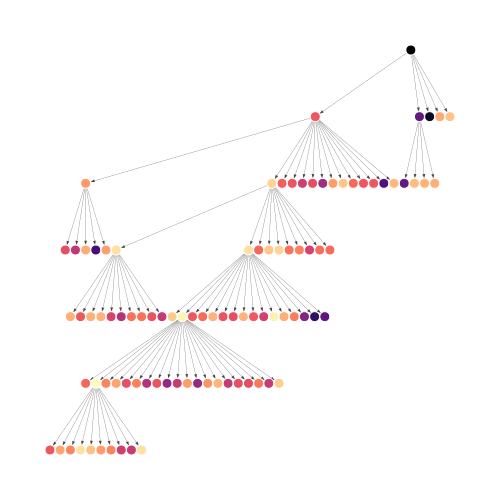

In [448]:
scores = docking_oracle([
    dg.molecule.Molecule(v)
    for v in g.get_vertex_dataframe()['name']
    if v != 'parent'
])

layout = g.layout("rt")

ig.plot(
    g,
    layout=layout,
    bbox=(500, 500),
    vertex_color=palette(normalize_array(scores)).tolist(),
    vertex_frame_color='white',
    edge_width=0.25,
    colorbar=palette,
    edge_arrow_size=0.3,
    margin=50,
    vertex_size=10,
)

Ridgeline plot.

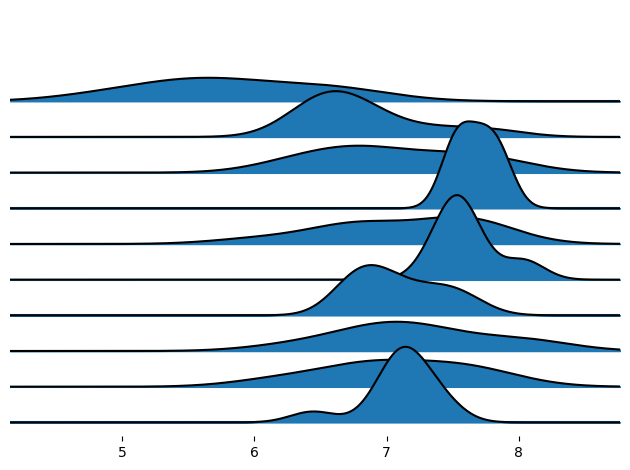

In [523]:
import joypy
import pandas as pd

ridgeline_plot = []
for group in drug_env.library.annotations.groupby('timestep'):
    smiles = group[1]['smiles']
    molecules = [dg.molecule.Molecule(s) for s in smiles]
    scores = docking_oracle(molecules)
    ridgeline_plot.append(scores)
    
fig, axes = joypy.joyplot(
    ridgeline_plot,
)